[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/StatMixedML/LightGBMLSS/blob/master/examples/simulation_example_Gamma.ipynb)

# Imports

In [14]:
from lightgbmlss.model import *
from lightgbmlss.distributions.Gamma import *

from sklearn import datasets
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

import plotnine
from plotnine import *
plotnine.options.figure_size = (18, 9)

# Data

In [2]:
housing_data = datasets.fetch_california_housing()
X, y = housing_data["data"], housing_data["target"]
feature_names = housing_data["feature_names"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

dtrain = lgb.Dataset(X_train, label=y_train)

# Distribution Selection

In [3]:
# Specifies Gamma distribution with softplus response function and option to stabilize Gradient/Hessian. See ?Gamma for an overview.
lgblss = LightGBMLSS(
    Gamma(stabilization="None",   # Options are "None", "MAD", "L2".
          response_fn="softplus", # Function to transform the concentration and rate parameters, e.g., "exp" or "softplus".
          loss_fn="nll"           # Loss function. Options are "nll" (negative log-likelihood) or "crps"(continuous ranked probability score).
         ) 
)

# Hyper-Parameter Optimization

In [4]:
# Any LightGBM hyperparameter can be tuned, where the structure of the parameter dictionary needs to be as follows:

    # Float/Int sample_type
        # {"param_name": ["sample_type", low, high, log]}
            # sample_type: str, Type of sampling, e.g., "float" or "int"
            # low: int, Lower endpoint of the range of suggested values
            # high: int, Upper endpoint of the range of suggested values
            # log: bool, Flag to sample the value from the log domain or not
    # Example: {"eta": "float", low=1e-5, high=1, log=True]}

    # Categorical sample_type
        # {"param_name": ["sample_type", ["choice1", "choice2", "choice3", "..."]]}
            # sample_type: str, Type of sampling, either "categorical"
            # choice1, choice2, choice3, ...: str, Possible choices for the parameter
        # Example: {"boosting": ["categorical", ["gbdt", "dart"]]}

    # For parameters without tunable choice (this is needed if tree_method = "gpu_hist" and gpu_id needs to be specified)
        # {"param_name": ["none", [value]]},
        # param_name: str, Name of the parameter
        # value: int, Value of the parameter
    # Example: {"gpu_id": ["none", [0]]}

param_dict = {
    "eta":                      ["float", {"low": 1e-5,   "high": 1,     "log": True}],
    "max_depth":                ["int",   {"low": 1,      "high": 10,    "log": False}],
    "subsample":                ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "feature_fraction":         ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "boosting":                 ["categorical", ["gbdt"]],
}

np.random.seed(123)
opt_param = lgblss.hyper_opt(param_dict,
                             dtrain,
                             num_boost_round=100,        # Number of boosting iterations.
                             nfold=5,                    # Number of cv-folds.
                             early_stopping_rounds=20,   # Number of early-stopping rounds
                             max_minutes=5,              # Time budget in minutes, i.e., stop study after the given number of minutes.
                             n_trials=None,              # The number of trials. If this argument is set to None, there is no limitation on the number of trials.
                             silence=False,              # Controls the verbosity of the trail, i.e., user can silence the outputs of the trail.
                             seed=123,                   # Seed used to generate cv-folds.
                             hp_seed=None                # Seed for random number generator used in the Bayesian hyperparameter search.
                             )

[I 2023-06-15 08:03:03,230] A new study created in memory with name: LightGBMLSS Hyper-Parameter Optimization
C:\Users\maerzale\.virtualenvs\LightGBMLSS-Dam57Fpb\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


   0%|          | 00:00/05:00

[I 2023-06-15 08:03:16,944] Trial 0 finished with value: 2759.266148987452 and parameters: {'eta': 0.09603407929961807, 'max_depth': 10, 'subsample': 0.7613846734579666, 'feature_fraction': 0.5598064486359382, 'boosting': 'gbdt'}. Best is trial 0 with value: 2759.266148987452.
[I 2023-06-15 08:03:28,801] Trial 1 finished with value: 3346.918695534035 and parameters: {'eta': 0.014381673128798216, 'max_depth': 6, 'subsample': 0.9501612719320804, 'feature_fraction': 0.7427055702196736, 'boosting': 'gbdt'}. Best is trial 0 with value: 2759.266148987452.
[I 2023-06-15 08:03:41,157] Trial 2 finished with value: 2602.3501491166558 and parameters: {'eta': 0.13298333541196447, 'max_depth': 8, 'subsample': 0.8558663888442231, 'feature_fraction': 0.4200678290205255, 'boosting': 'gbdt'}. Best is trial 2 with value: 2602.3501491166558.
[I 2023-06-15 08:03:52,564] Trial 3 finished with value: 4619.8771454390435 and parameters: {'eta': 0.0003220698144670632, 'max_depth': 4, 'subsample': 0.86590591202

# Model Training

In [5]:
np.random.seed(123)

opt_params = opt_param.copy()
n_rounds = opt_params["opt_rounds"]
del opt_params["opt_rounds"]

# Train Model with optimized hyperparameters
lgblss.train(opt_params,
             dtrain,
             num_boost_round=n_rounds
             )

# Prediction

In [6]:
# Set seed for reproducibility
torch.manual_seed(123)

# Number of samples to draw from predicted distribution
n_samples = 1000
quant_sel = [0.05, 0.95] # Quantiles to calculate from predicted distribution

# Sample from predicted distribution
pred_samples = lgblss.predict(X_test,
                              pred_type="samples",
                              n_samples=n_samples,
                              seed=123)

# Calculate quantiles from predicted distribution
pred_quantiles = lgblss.predict(X_test,
                                pred_type="quantiles",
                                n_samples=n_samples,
                                quantiles=quant_sel)

# Returns predicted distributional parameters
pred_params = lgblss.predict(X_test,
                             pred_type="parameters")

In [7]:
pred_samples.head()

,y_sample0,y_sample1,y_sample2,y_sample3,y_sample4,y_sample5,y_sample6,y_sample7,y_sample8,y_sample9,...,y_sample990,y_sample991,y_sample992,y_sample993,y_sample994,y_sample995,y_sample996,y_sample997,y_sample998,y_sample999
0,2.176237,3.090966,2.351205,2.962557,2.443776,2.252984,2.673520,2.451264,1.677721,2.714163,...,2.235156,2.229394,1.780779,1.691970,2.912359,2.061972,2.299920,2.435192,2.205722,3.006855
1,0.955924,0.792653,1.088152,0.963909,1.068848,0.928887,1.143481,0.713515,1.043469,0.639251,...,1.454571,0.556112,0.829367,0.933032,1.037109,1.156489,1.075186,1.177631,0.970985,1.089402
2,0.999609,2.000237,1.890290,1.386595,1.218006,1.105973,1.282551,1.024398,0.809715,1.253922,...,1.930563,1.217956,1.272420,1.555868,1.347978,1.229498,1.239482,1.069564,1.590961,1.117791
3,2.064673,2.126880,1.265026,1.700869,2.449878,1.834517,2.470263,2.503480,2.001798,1.537750,...,2.018410,2.336578,1.915797,1.743881,1.276189,1.850932,1.983994,1.740866,2.218034,2.111615
4,3.937543,1.897918,2.071925,3.357884,3.438909,3.016109,4.027487,3.529469,2.571341,4.337390,...,1.727211,4.099633,5.075980,3.758886,4.135426,3.420576,3.442622,4.471154,3.664294,3.582276


In [8]:
pred_quantiles.head()

,quant_0.05,quant_0.95
0,1.497817,3.184757
1,0.572076,1.417728
2,0.891822,2.000357
3,1.351815,2.733242
4,2.609397,5.141275


In [9]:
pred_params.head()

,concentration,rate
0,20.461550,9.021194
1,13.715843,14.465242
2,16.477320,11.801141
3,22.453886,11.197639
4,23.289742,6.233214


# SHAP Interpretability

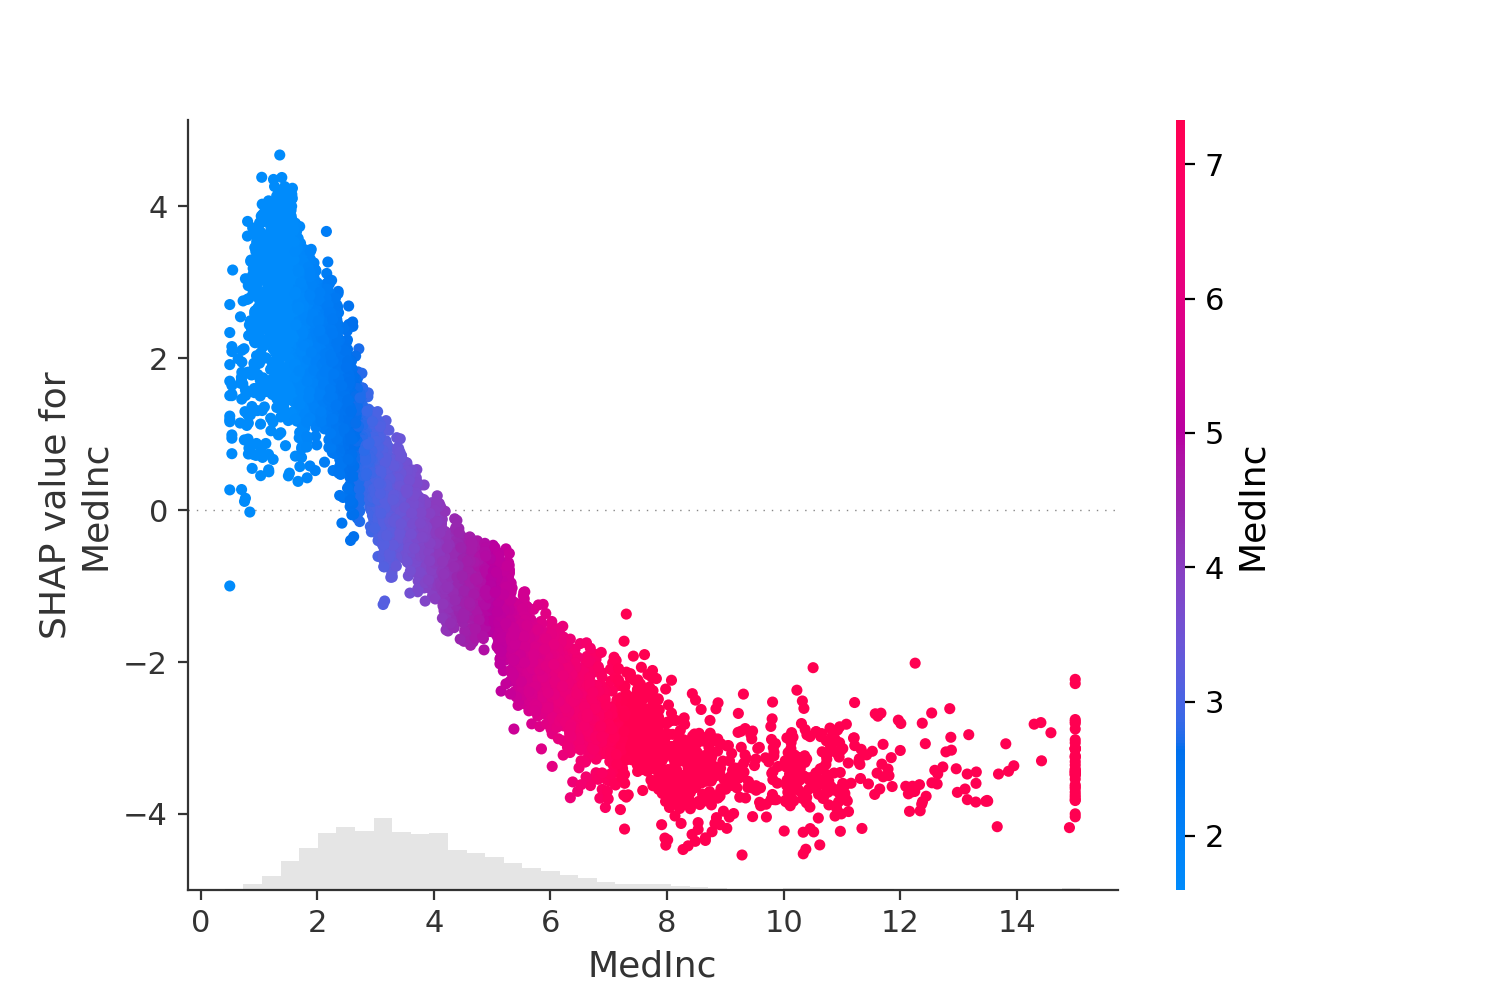

In [24]:
# Partial Dependence Plot
pdp_df = pd.DataFrame(X_train, columns=feature_names)
lgblss.plot(pdp_df,
            parameter="rate",
            feature=feature_names[0],
            plot_type="Partial_Dependence")

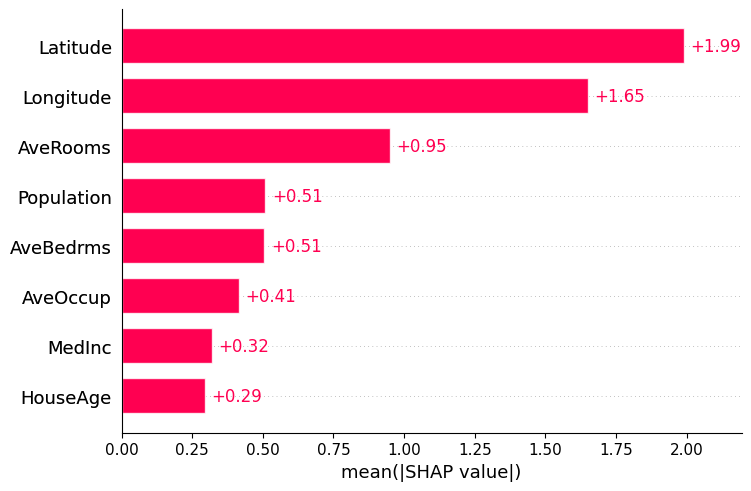

In [11]:
# Feature Importance
lgblss.plot(pdp_df,
            parameter="concentration",
            plot_type="Feature_Importance")

# Density Plots of Actual and Predicted Samples

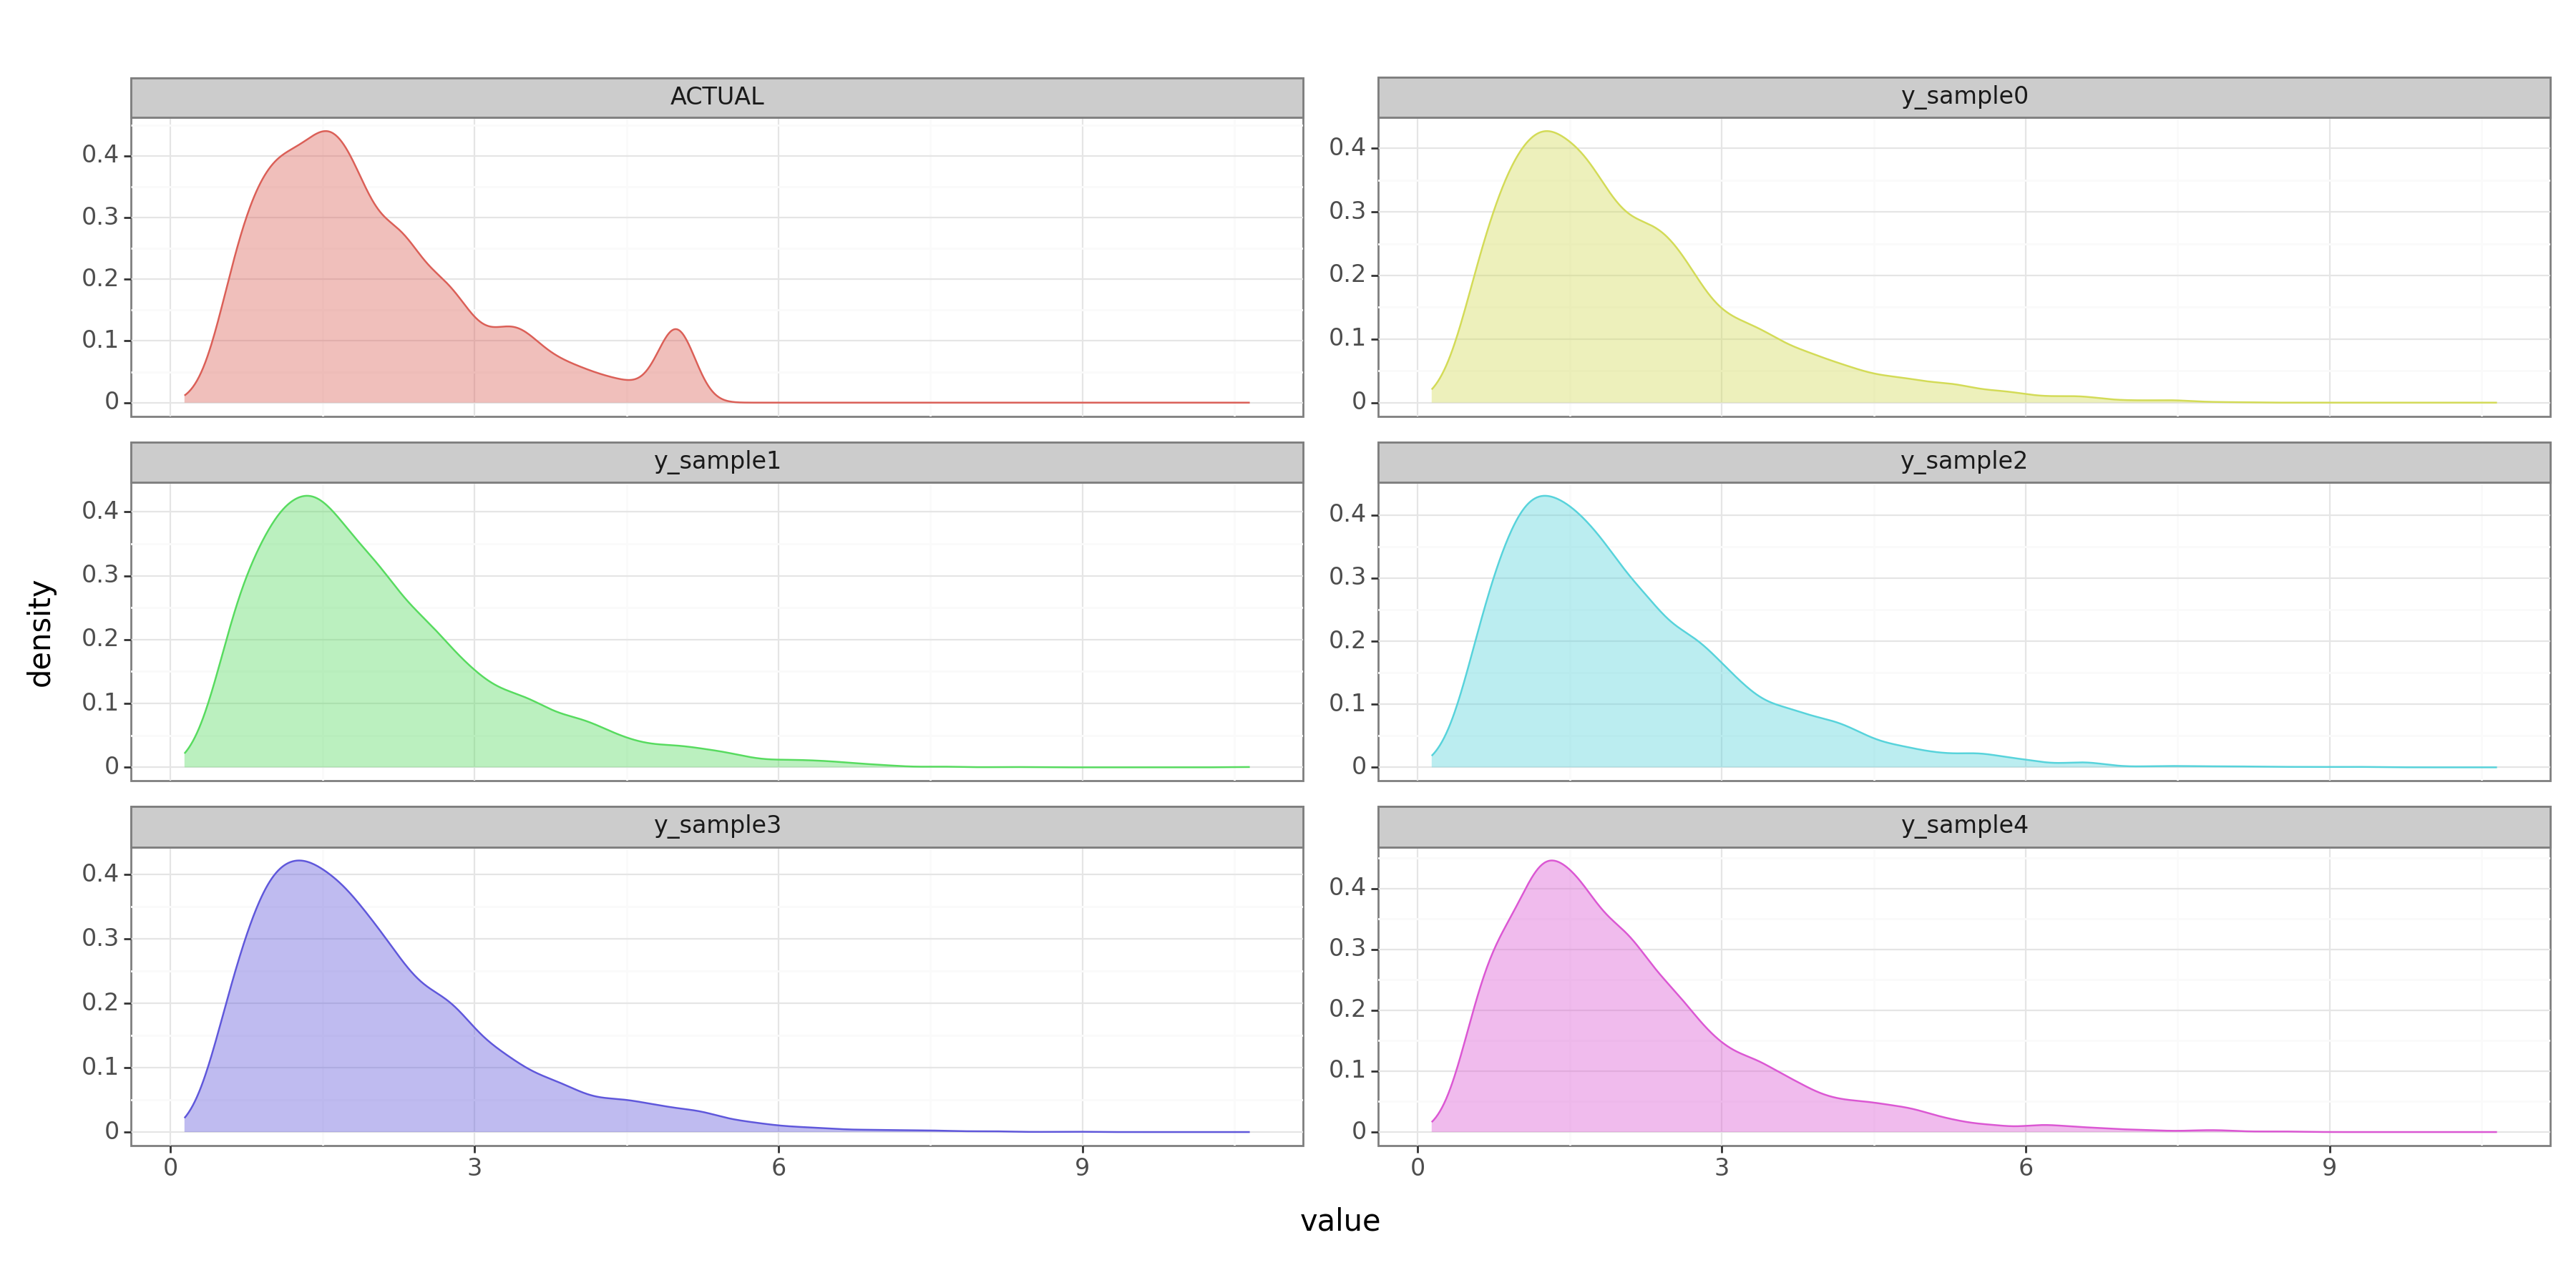

<Figure Size: (1800 x 900)>

In [15]:
pred_df = pd.melt(pred_samples.iloc[:,0:5])
actual_df = pd.DataFrame.from_dict({"variable": "ACTUAL", "value": y_test.reshape(-1,)})
plot_df = pd.concat([pred_df, actual_df])

(
    ggplot(plot_df, 
           aes(x="value",
               color="variable",
               fill="variable")) +  
    geom_density(alpha=0.4) + 
    facet_wrap("variable",
              scales="free_y",
              ncol=2) + 
    theme_bw(base_size=15) + 
    theme(legend_position="none")
)